# Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.
## Описание услуг

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);- Выделенная линия технической поддержки (TechSupport);- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.










In [1]:
import pandas as pd

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import math
import shap
import phik
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from optuna.integration import OptunaSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import time
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)
from sklearn.metrics import roc_curve, auc
from sklearn.inspection import permutation_importance
from optuna.distributions import ( 
    IntDistribution, 
    CategoricalDistribution,
    FloatDistribution
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder,
    MinMaxScaler,
    LabelEncoder
)
from sklearn.metrics import roc_curve, auc
from catboost import CatBoostClassifier

from sklearn.neighbors import KNeighborsClassifier

RANDOM_STATE=301023
warnings.filterwarnings('ignore')

# Загрузка данных

In [2]:
try:
    contract_new = pd.read_csv('contract_new.csv')
except:
    contract_new = pd.read_csv('/datasets/contract_new.csv')
contract_new.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [3]:
try:
    internet_new = pd.read_csv('internet_new.csv')
except:
    internet_new = pd.read_csv('/datasets/internet_new.csv')
internet_new.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [4]:
try:
    personal_new = pd.read_csv('personal_new.csv')
except:
    personal_new = pd.read_csv('/datasets/personal_new.csv')
personal_new.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
try:
    phone_new = pd.read_csv('phone_new.csv')
except:
    phone_new = pd.read_csv('/datasets/phone_new.csv')
phone_new.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Данные были успешно загружены. 

# Предобработка данных

## contract_new

In [6]:
contract_new.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Как видим, в TotalCharges неверный тип данных, там должны быть числа, а хранятся строки. Исправим это, но сначала уберем пропуски.

In [8]:
contract_new[contract_new['TotalCharges']==' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Пропуски в столбце TotalCharges у пользователей, которые начали оплачивать услуги в день выгрузки данных, заменим их на MonthlyCharges, это будет общая сумма транзакций.

In [9]:
contract_new['TotalCharges'].replace(' ', pd.NA, inplace=True)
contract_new['TotalCharges'].fillna(contract_new['MonthlyCharges'], inplace=True)
contract_new[contract_new['TotalCharges']==' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


In [10]:
contract_new['TotalCharges'] = contract_new['TotalCharges'].astype(float)
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Кроме того, нужно преобразовать BeginDate и EndDate в тип данных дата и время. 

In [11]:
contract_new['BeginDate'] = pd.to_datetime(contract_new['BeginDate'])
contract_new['EndDate'] = pd.to_datetime(contract_new['EndDate'], errors='coerce')
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [12]:
contract_new.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50


Теперь получили верные типы данных. Проверим дубликаты в object столбцах.

In [13]:
for column in contract_new.select_dtypes(include='object').columns:
    print(column, contract_new[column].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Type ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [14]:
contract_new[contract_new['customerID'].duplicated()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


In [15]:
contract_new[contract_new['customerID'].str.lower().duplicated()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


В столбцах object не наблюдается ни явных ни не явных дубликатов.

## internet_new

In [16]:
internet_new.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [17]:
internet_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Все типы данных соотетствуют, пропуски отсутствуют. Проверим дубликаты.

In [18]:
for column in internet_new.select_dtypes(include='object').columns:
    print(column, internet_new[column].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
InternetService ['DSL' 'Fiber optic']
OnlineSecurity ['No' 'Yes']
OnlineBackup ['Yes' 'No']
DeviceProtection ['No' 'Yes']
TechSupport ['No' 'Yes']
StreamingTV ['No' 'Yes']
StreamingMovies ['No' 'Yes']


In [19]:
internet_new[internet_new['customerID'].duplicated()]

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies


In [20]:
internet_new[internet_new['customerID'].str.lower().duplicated()]

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies


Никаких дубликатов не обнаружено.

## personal_new

In [21]:
personal_new.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [22]:
personal_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Пропуски отсутствуют и типы данных соответствуют. Проверим на дубликаты.

In [23]:
for column in personal_new.select_dtypes(include='object').columns:
    print(column, personal_new[column].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']


In [24]:
personal_new[personal_new['customerID'].duplicated()]

,customerID,gender,SeniorCitizen,Partner,Dependents


In [25]:
personal_new[personal_new['customerID'].str.lower().duplicated()]

,customerID,gender,SeniorCitizen,Partner,Dependents


Дубликатов не обнаружено.

## phone_new

In [26]:
phone_new.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [27]:
phone_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Пропусков не обнаружено, с типами данных все в порядке.

In [28]:
for column in phone_new.select_dtypes(include='object').columns:
    print(column, phone_new[column].unique())

customerID ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
MultipleLines ['No' 'Yes']


In [29]:
phone_new[phone_new['customerID'].duplicated()]

,customerID,MultipleLines


In [30]:
phone_new[phone_new['customerID'].str.lower().duplicated()]

,customerID,MultipleLines


Дубликатов нет.

## Вывод

Была проведена базовая предобработка данных. Данные были проверены на пропуски, соответствие типов данных и дубликаты. Данные были приведены к правильному виду, типы данных приведены в соответствие, пропуски и дубликаты не были обнаружены.

# Исследовательский анализ данных

## Объединение таблиц

In [31]:
contract_new.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50


In [32]:
internet_new.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [33]:
personal_new.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [34]:
phone_new.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [35]:
df = contract_new.merge(internet_new, on='customerID', how='outer')\
               .merge(personal_new, on='customerID', how='outer')\
               .merge(phone_new, on='customerID', how='outer')
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,0002-ORFBO,2019-05-01,NaT,One year,Yes,Mailed check,65.6,631.73,DSL,No,Yes,No,Yes,Yes,No,Female,0,Yes,Yes,No
1,0003-MKNFE,2019-05-01,NaT,Month-to-month,No,Mailed check,59.9,539.10,DSL,No,No,No,No,No,Yes,Male,0,No,No,Yes
2,0004-TLHLJ,2019-09-01,NaT,Month-to-month,Yes,Electronic check,73.9,406.45,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No,No
3,0011-IGKFF,2018-12-01,NaT,Month-to-month,Yes,Electronic check,98.0,1372.00,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,1,Yes,No,No
4,0013-EXCHZ,2019-09-01,NaT,Month-to-month,Yes,Mailed check,83.9,444.67,Fiber optic,No,No,No,Yes,Yes,No,Female,1,Yes,No,No


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovies   5517 n

Добавим признак, показывающий ушел ли клиент, для этого посмотрим, если ли пропуск в EndDate. Если есть, значит, клиент еще не ушел, если нет, значит ушел. Добавим признак. 

In [37]:
df['IsGone'] = ~df['EndDate'].isnull()
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,IsGone
0,0002-ORFBO,2019-05-01,NaT,One year,Yes,Mailed check,65.6,631.73,DSL,No,...,No,Yes,Yes,No,Female,0,Yes,Yes,No,False
1,0003-MKNFE,2019-05-01,NaT,Month-to-month,No,Mailed check,59.9,539.10,DSL,No,...,No,No,No,Yes,Male,0,No,No,Yes,False
2,0004-TLHLJ,2019-09-01,NaT,Month-to-month,Yes,Electronic check,73.9,406.45,Fiber optic,No,...,Yes,No,No,No,Male,0,No,No,No,False
3,0011-IGKFF,2018-12-01,NaT,Month-to-month,Yes,Electronic check,98.0,1372.00,Fiber optic,No,...,Yes,No,Yes,Yes,Male,1,Yes,No,No,False
4,0013-EXCHZ,2019-09-01,NaT,Month-to-month,Yes,Mailed check,83.9,444.67,Fiber optic,No,...,No,Yes,Yes,No,Female,1,Yes,No,No,False


## Исследовательский анализ данных

Добавим столбец, показывающий сколько дней люди уже пользуются услугами, пропуски в EndDate заполним 1 февраля 2020, так как это дата выгрузки таблицы.

In [38]:
df['UsageTime'] = pd.to_timedelta((df['EndDate'].fillna("2020-02-01") - df['BeginDate']).fillna(0)).dt.days
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,IsGone,UsageTime
0,0002-ORFBO,2019-05-01,NaT,One year,Yes,Mailed check,65.6,631.73,DSL,No,...,Yes,Yes,No,Female,0,Yes,Yes,No,False,276
1,0003-MKNFE,2019-05-01,NaT,Month-to-month,No,Mailed check,59.9,539.10,DSL,No,...,No,No,Yes,Male,0,No,No,Yes,False,276
2,0004-TLHLJ,2019-09-01,NaT,Month-to-month,Yes,Electronic check,73.9,406.45,Fiber optic,No,...,No,No,No,Male,0,No,No,No,False,153
3,0011-IGKFF,2018-12-01,NaT,Month-to-month,Yes,Electronic check,98.0,1372.00,Fiber optic,No,...,No,Yes,Yes,Male,1,Yes,No,No,False,427
4,0013-EXCHZ,2019-09-01,NaT,Month-to-month,Yes,Mailed check,83.9,444.67,Fiber optic,No,...,Yes,Yes,No,Female,1,Yes,No,No,False,153


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovies   5517 n

Нужно заполнить пропуски. Поступим следующим образом: в OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines заменим на No. В EndDate ничего не будем менять, так как во избежании утечки данных этот признак нужно будет удалить при обучении. Кроме того, преобразум SeniorCitizen в Object, так как он категориальный.

Построим гистограммы для категориальных признаков, ушедших и оставшихся отметим разными цветами.

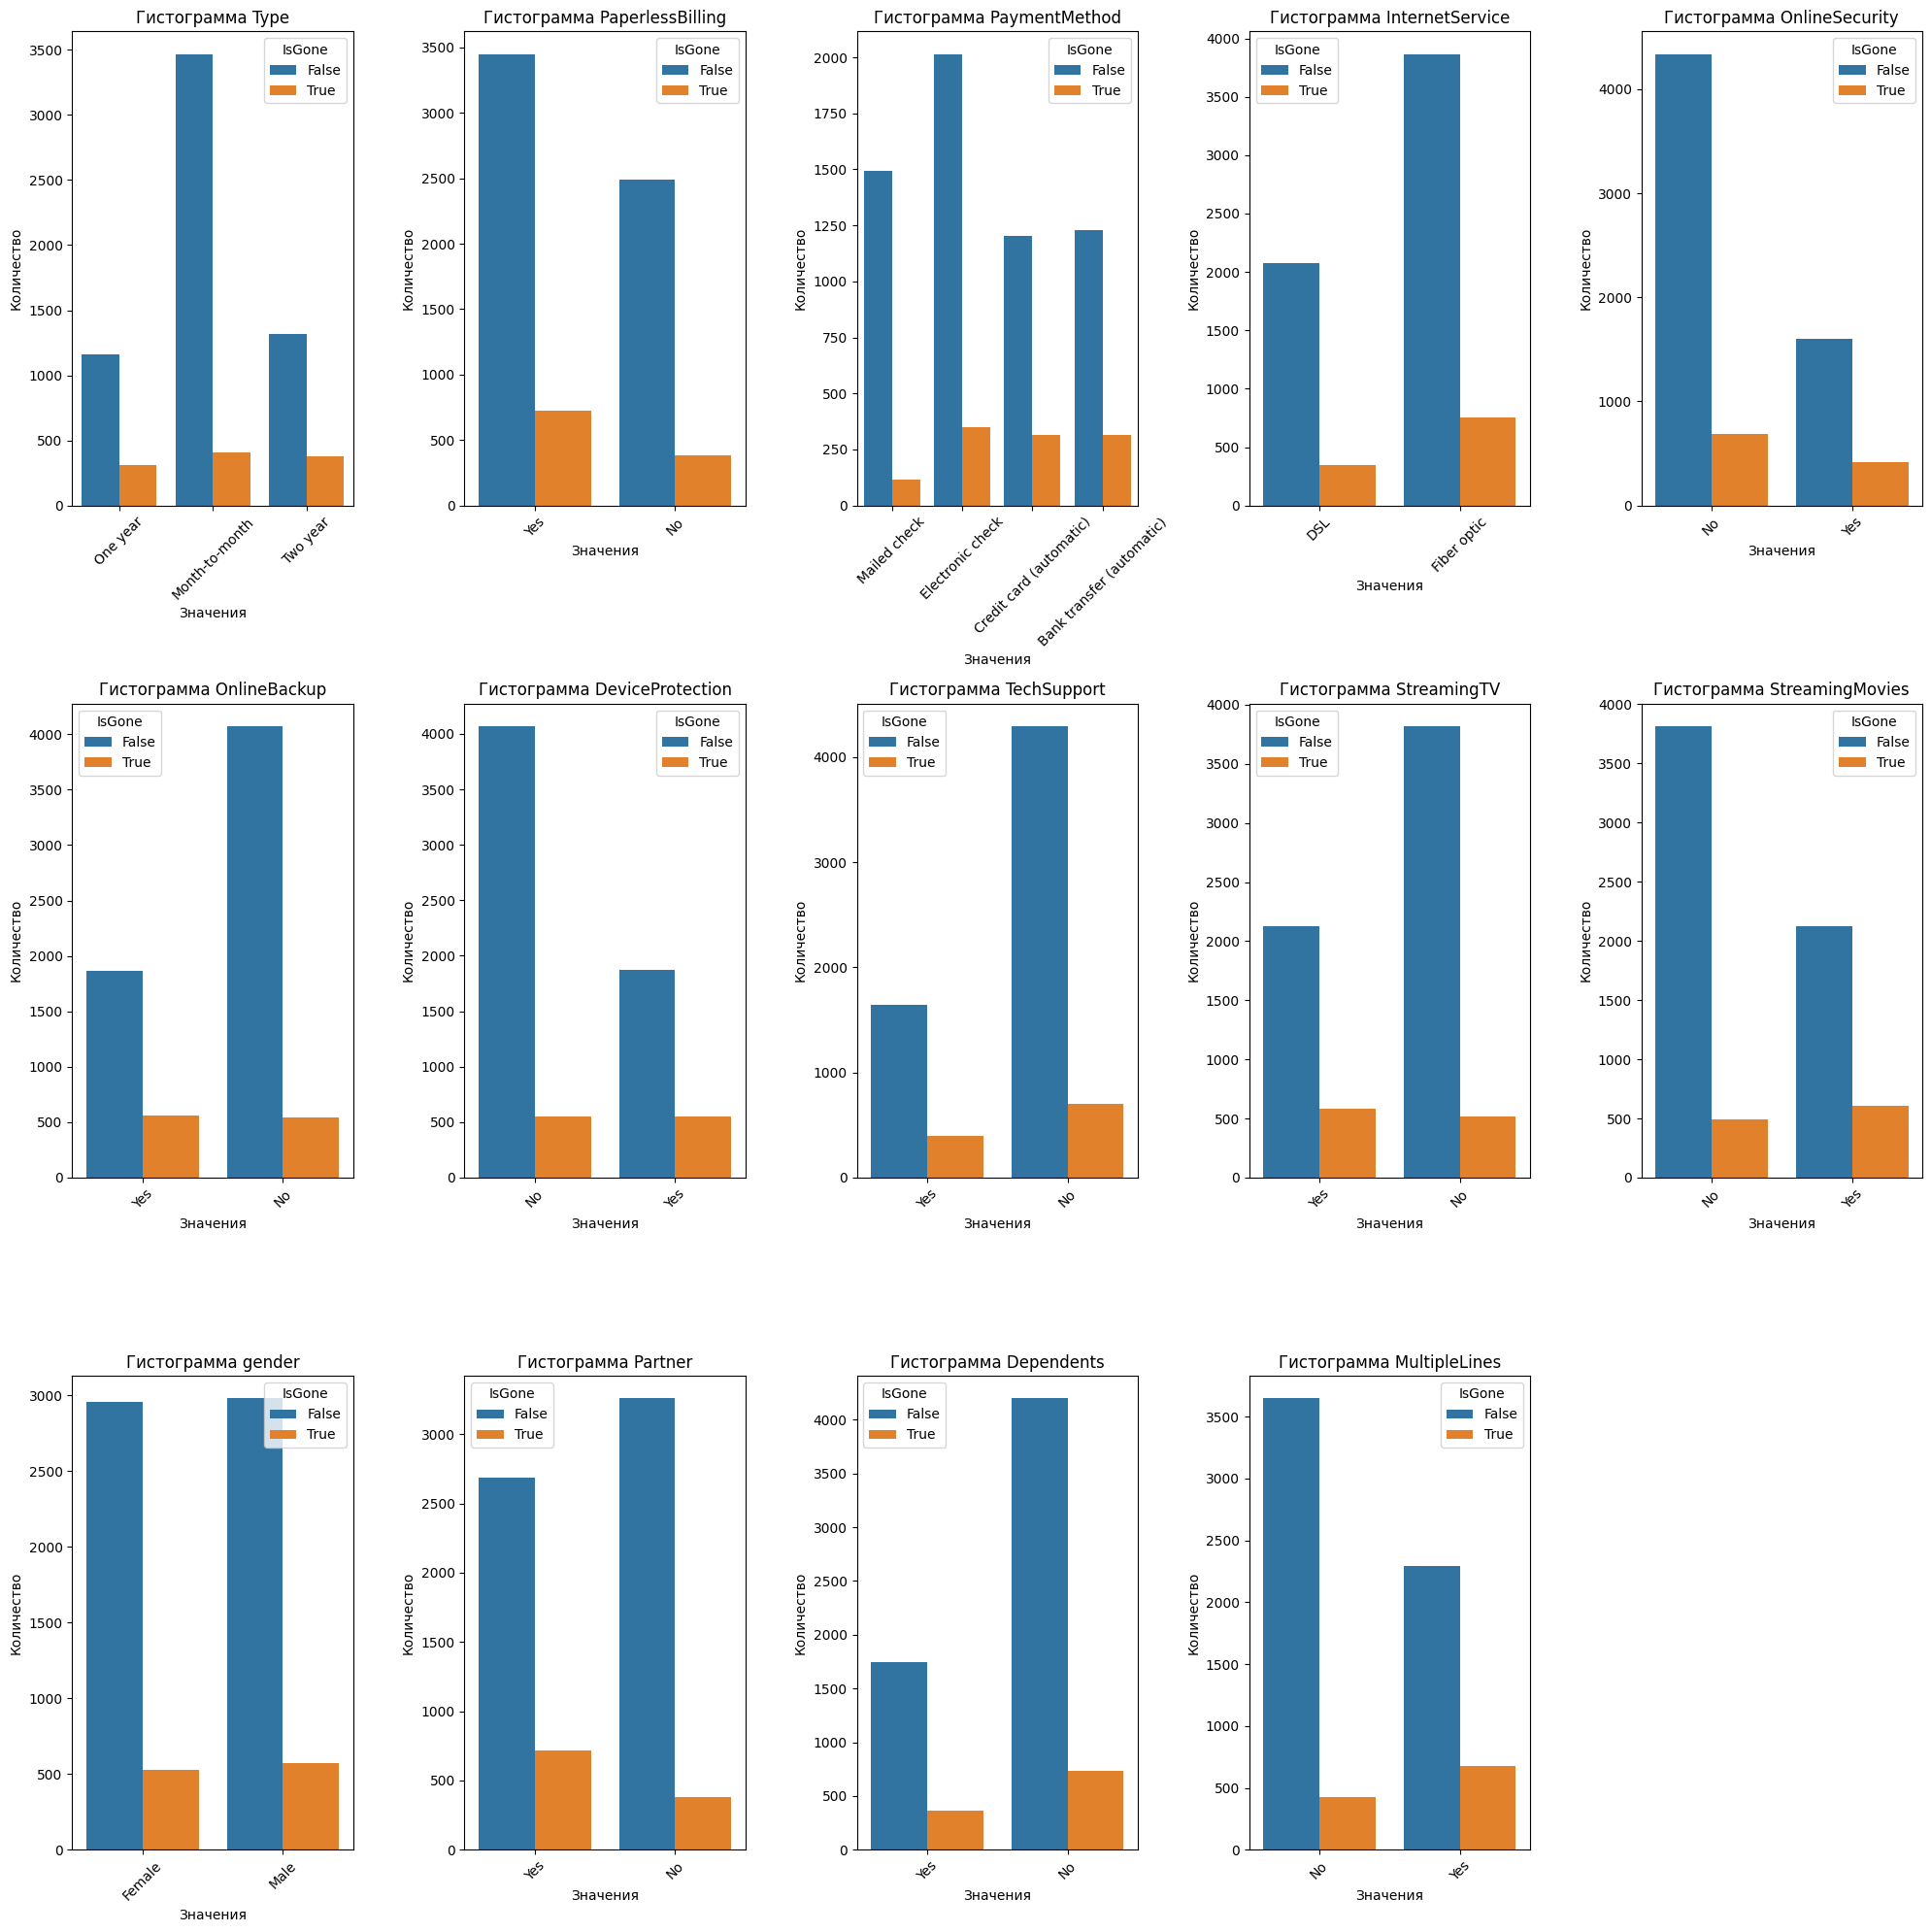

In [40]:
df['OnlineSecurity'].fillna('No', inplace=True)
df['OnlineBackup'].fillna('No', inplace=True)
df['DeviceProtection'].fillna('No', inplace=True)
df['TechSupport'].fillna('No', inplace=True)
df['StreamingTV'].fillna('No', inplace=True)
df['StreamingMovies'].fillna('No', inplace=True)
df['MultipleLines'].fillna('No', inplace=True)
df['MultipleLines'].fillna('No', inplace=True)
df['InternetService'].fillna(df['InternetService'].mode()[0], inplace=True)

num_cols = df.select_dtypes(include='object').drop('customerID', axis=1).shape[1]
nrows = 3
ncols = math.ceil(num_cols / nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,20))
axs = axs.flatten()
for i, column in enumerate(df.select_dtypes(include='object').drop('customerID', axis=1).columns):
    sns.countplot(data=df, x=column, hue='IsGone', ax=axs[i])
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].set_xlabel('Значения')
    axs[i].set_ylabel('Количество')
    axs[i].set_title(f'Гистограмма {column}')
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

Различия между классами наблюдаются, но незначительные, посмотрим количественные признаки.

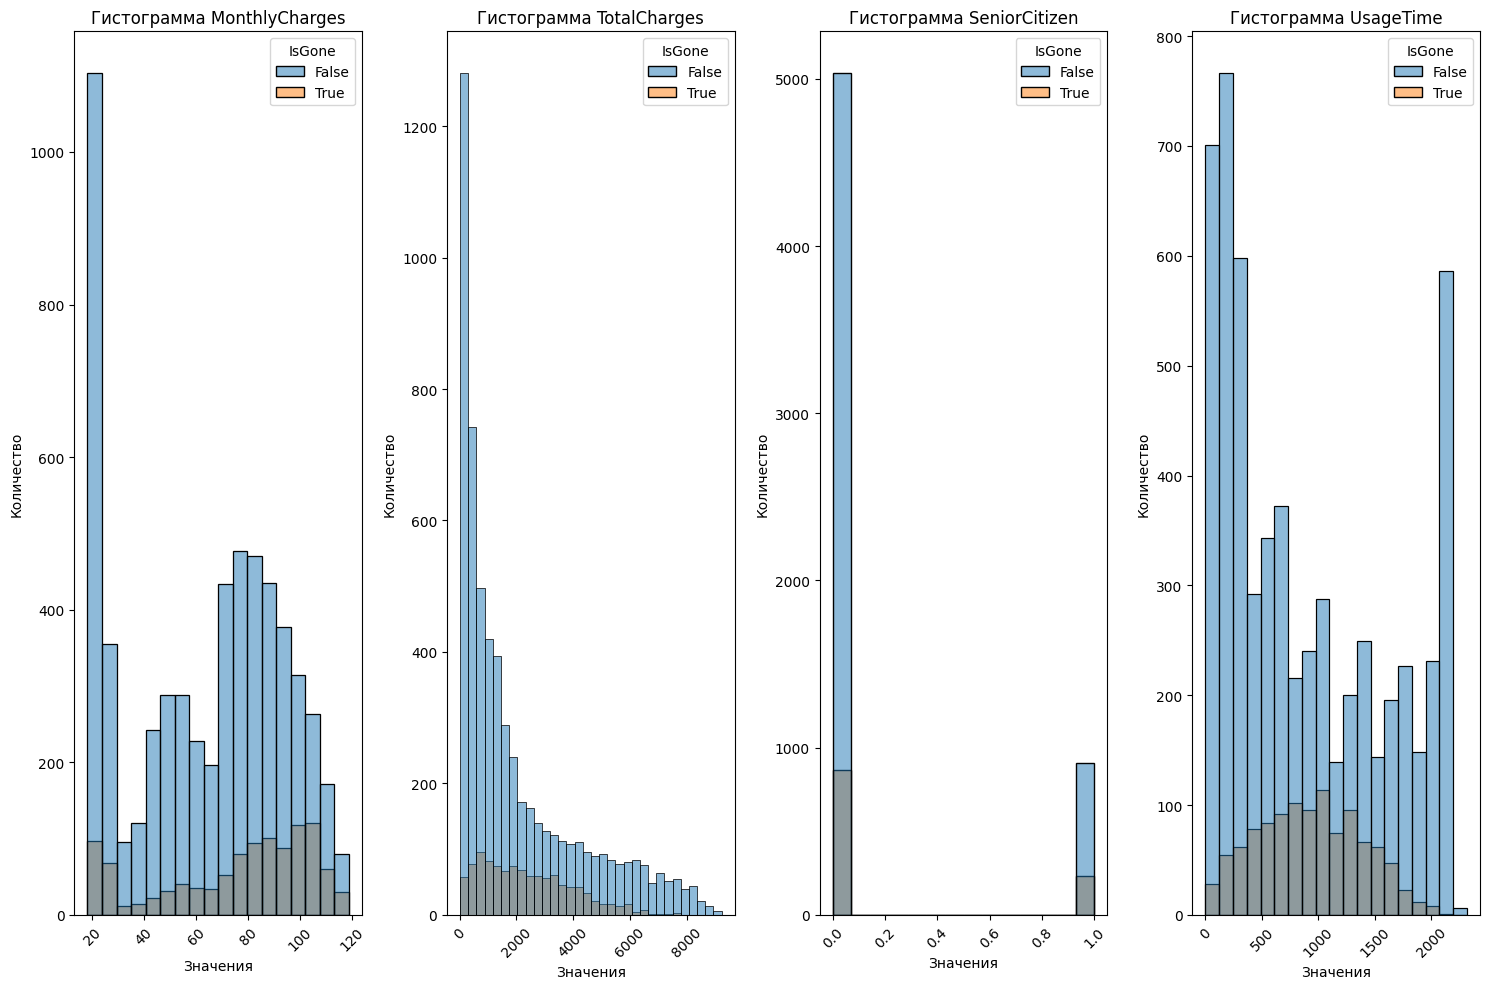

In [41]:
num_cols = df.select_dtypes(include='number').shape[1]
nrows = 1
ncols = math.ceil(num_cols / nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10))
axs = axs.flatten()
for i, column in enumerate(df.select_dtypes(include='number').columns):
    sns.histplot(data=df, x=column, hue='IsGone', ax=axs[i])
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].set_xlabel('Значения')
    axs[i].set_ylabel('Количество')
    axs[i].set_title(f'Гистограмма {column}')
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   InternetService   7043 non-null   object        
 9   OnlineSecurity    7043 non-null   object        
 10  OnlineBackup      7043 non-null   object        
 11  DeviceProtection  7043 non-null   object        
 12  TechSupport       7043 non-null   object        
 13  StreamingTV       7043 non-null   object        
 14  StreamingMovies   7043 n

В целом, распределения похожи, но интересно, что время пользования ушедших пользователей стремится к нормальному распределению со средним в 1000 то есть около 3 лет. 

## Корреляционный анализ данных

In [43]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,IsGone,UsageTime
0,0002-ORFBO,2019-05-01,NaT,One year,Yes,Mailed check,65.6,631.73,DSL,No,...,Yes,Yes,No,Female,0,Yes,Yes,No,False,276
1,0003-MKNFE,2019-05-01,NaT,Month-to-month,No,Mailed check,59.9,539.10,DSL,No,...,No,No,Yes,Male,0,No,No,Yes,False,276
2,0004-TLHLJ,2019-09-01,NaT,Month-to-month,Yes,Electronic check,73.9,406.45,Fiber optic,No,...,No,No,No,Male,0,No,No,No,False,153
3,0011-IGKFF,2018-12-01,NaT,Month-to-month,Yes,Electronic check,98.0,1372.00,Fiber optic,No,...,No,Yes,Yes,Male,1,Yes,No,No,False,427
4,0013-EXCHZ,2019-09-01,NaT,Month-to-month,Yes,Mailed check,83.9,444.67,Fiber optic,No,...,Yes,Yes,No,Female,1,Yes,No,No,False,153


Построим матрицу корреляции. Перед этим удалим признаки BeginDate, EndDate и CustomerID, потому что их не получится использовать для предсказания.

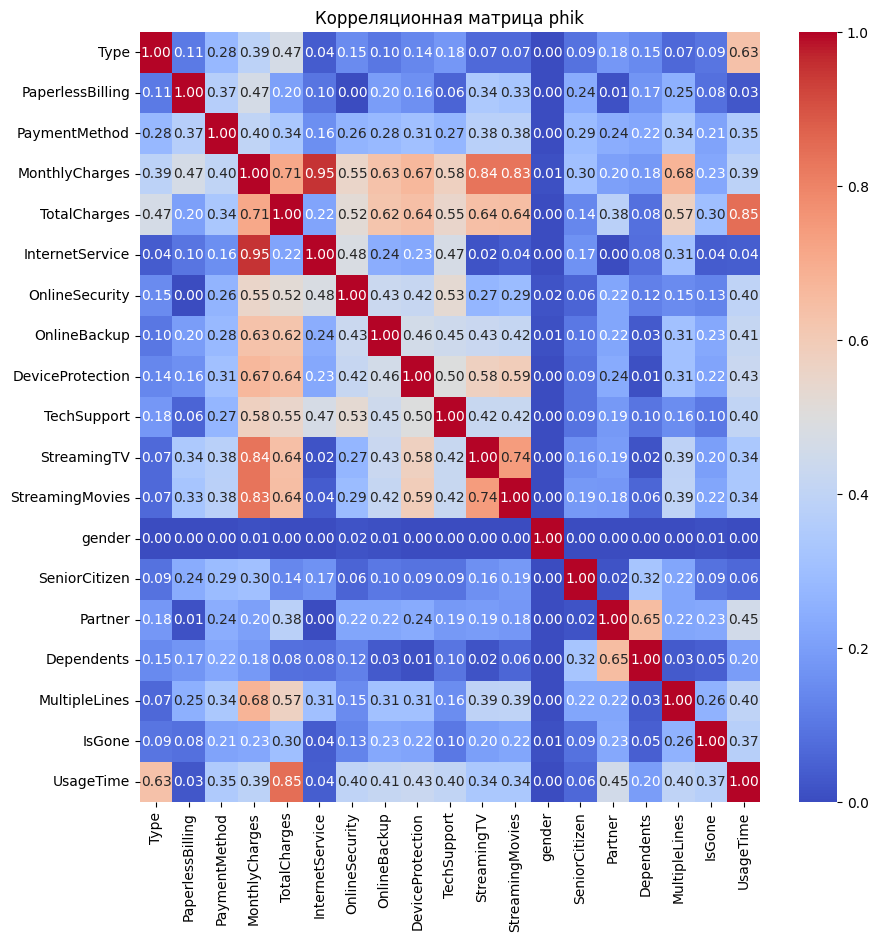

In [44]:
plt.figure(figsize=(10,10))
sns.heatmap(df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1).phik_matrix(interval_cols=df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1).select_dtypes(include=np.number)), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица phik')
plt.show();

У всех признаков не особо высокая корреляция с IsGone.

## Вывод

В ходе анализа данные были объединены в единую таблицу и исследованы по количественным и категориальным признакам. Построенные графики показали, что для большинства признаков наблюдается схожее распределение. Примечательно, что корреляция признаков с таргетом оказалась не слишком высокой, что может указывать на необходимость дальнейшего поиска более значимых факторов. Одним из интересных выводов стало то, что клиенты чаще всего покидают компанию спустя примерно три года работы. 

# Создание моделей

Будем использовать для построения модели kNN и CatBoostClassifier. 

## Разбиение данных

Разобьем данные на тренировочную, тестовую и валидационную выборки и создадим предобработчики.

In [45]:
X = df.drop(['IsGone'], axis=1)
y = df['IsGone']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train, 
    test_size=0.1,
    random_state=RANDOM_STATE
)



Создадим предобработчик данных, будем использовать OrdinalEncoder и StandardScaler. Столбцы customerID, BeginDate, EndDate использовать не будем.

In [46]:
cat_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup',\
              'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 
              'Partner', 'Dependents', 'MultipleLines']
num_columns = ['MonthlyCharges', 'TotalCharges', 'UsageTime']

columns_to_drop = ['EndDate', 'BeginDate', 'customerID']

def drop_columns(X, columns):
    return X.drop(columns, axis=1)

drop_columns_transformer = FunctionTransformer(drop_columns, kw_args={'columns': columns_to_drop})

ord_pipe = Pipeline(
    [
        (
            'ord', OrdinalEncoder(
                handle_unknown='use_encoded_value',
                unknown_value=-1
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=-1, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('coder', 'passthrough', cat_columns),
        ('scaler', 'passthrough', num_columns),
    ], 
    remainder='passthrough'
)

pipe = Pipeline(
    [
        ('drop_columns', drop_columns_transformer),
        ('preprocessor', data_preprocessor),
        ('model', None)
    ]
)

## kNN

Начнем с kNN. Переберем параметры с помощью Optuna.

In [47]:
param_grid_knn = {
    'model': CategoricalDistribution([KNeighborsClassifier()]),
    'model__n_neighbors': IntDistribution(2, 100),
    'preprocessor__scaler': CategoricalDistribution(['passthrough', StandardScaler(), MinMaxScaler()]),
    'preprocessor__coder': CategoricalDistribution([ord_pipe]),
    'model__metric': CategoricalDistribution(['euclidean', 'minkowski']),
    'model__weights': CategoricalDistribution(['uniform', 'distance'])
}

oscv_knn = OptunaSearchCV(
    pipe, 
    param_grid_knn, 
    cv=5, 
    scoring='roc_auc',
    n_trials=50, 
    refit='roc_auc',
    random_state=RANDOM_STATE
)

start_time = time.time()
oscv_knn.fit(X_train, y_train) 
end_time = time.time()

execution_time_knn = end_time - start_time

[I 2024-09-12 13:58:53,909] A new study created in memory with name: no-name-d277c5c4-4c20-4e50-ac04-0f1496acde53
[I 2024-09-12 13:58:54,358] Trial 0 finished with value: 0.7441926876711875 and parameters: {'model': KNeighborsClassifier(metric='euclidean', n_neighbors=21), 'model__n_neighbors': 21, 'preprocessor__scaler': MinMaxScaler(), 'preprocessor__coder': Pipeline(steps=[('ord',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('simpleImputer_after_ord',
                 SimpleImputer(missing_values=-1, strategy='most_frequent'))]), 'model__metric': 'euclidean', 'model__weights': 'uniform'}. Best is trial 0 with value: 0.7441926876711875.
[I 2024-09-12 13:58:54,679] Trial 1 finished with value: 0.7502046200684017 and parameters: {'model': KNeighborsClassifier(metric='euclidean', n_neighbors=66), 'model__n_neighbors': 66, 'preprocessor__scaler': 'passthrough', 'preprocessor__coder': Pipeline(step

In [48]:
print('Лучшая метрика при кросс-валидации:', round(oscv_knn.best_score_, 3))
print('Время обучения и подбора параметров:', round(execution_time_knn, 2))
start_time = time.time()
oscv_knn.predict(X_val)
end_time = time.time()
print('Время предсказания на валидационной выборке:', round(end_time - start_time, 2))
print('Параметры лучшей модели:', oscv_knn.best_params_)

Лучшая метрика при кросс-валидации: 0.806
Время обучения и подбора параметров: 20.21
Время предсказания на валидационной выборке: 0.03
Параметры лучшей модели: {'model': KNeighborsClassifier(n_neighbors=96, weights='distance'), 'model__n_neighbors': 91, 'preprocessor__scaler': StandardScaler(), 'preprocessor__coder': Pipeline(steps=[('ord',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('simpleImputer_after_ord',
                 SimpleImputer(missing_values=-1, strategy='most_frequent'))]), 'model__metric': 'minkowski', 'model__weights': 'uniform'}


Как видим, данная модель не смогла показать подходящую метрику. Попробуем вывести важность признаков.

In [49]:
all_columns =  cat_columns + num_columns
explainer_knn_best = shap.Explainer(oscv_knn.best_estimator_['model'].predict, pd.DataFrame(oscv_knn.best_estimator_['preprocessor'].transform(X_val[0:100]) , columns=all_columns), random_state=RANDOM_STATE)
shap_values_knn_best = explainer_knn_best(pd.DataFrame(oscv_knn.best_estimator_['preprocessor'].transform(X_val[0:100]) , columns=all_columns))

PermutationExplainer explainer: 101it [03:46,  2.31s/it]                                                               


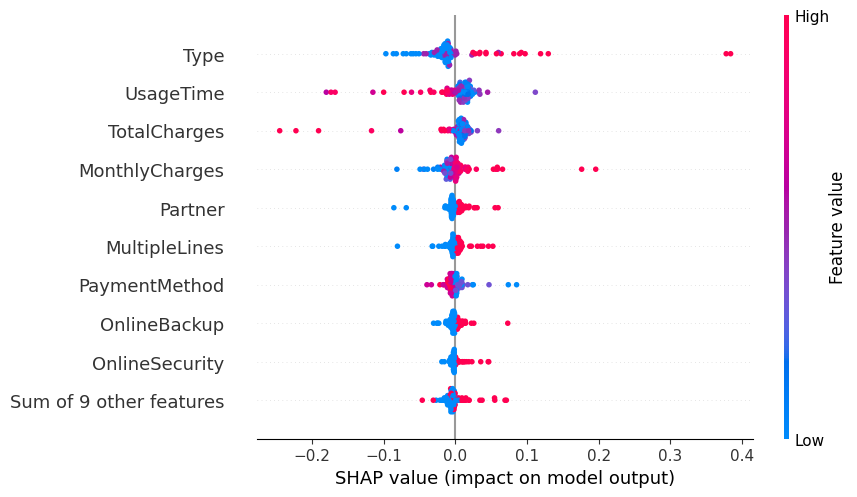

In [50]:
shap.plots.beeswarm(shap_values_knn_best) 

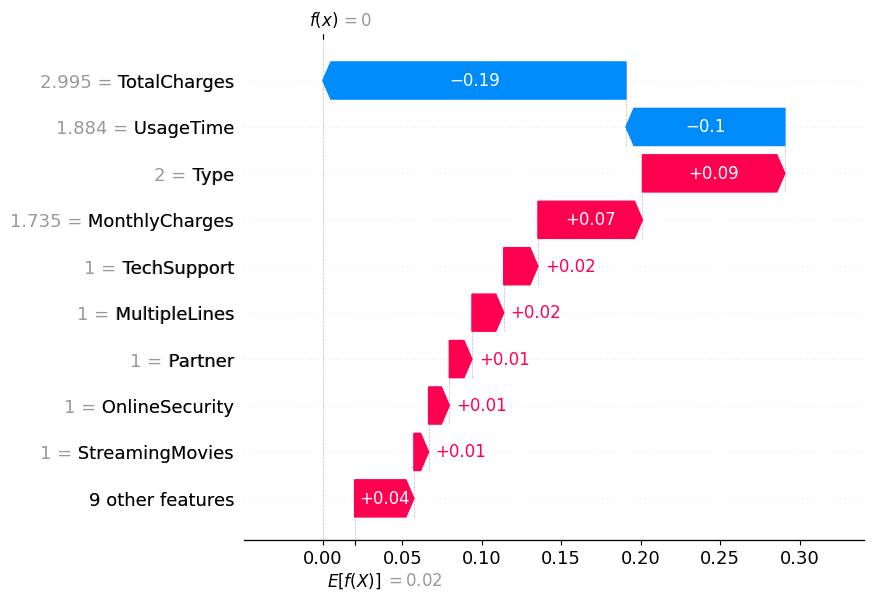

In [51]:
shap.plots.waterfall(shap_values_knn_best[5])

Признаки по важности представлены на графике выше.

Попробуем взять самые важные признаки, совместить их между собой и посмотреть получившуюся важность. Будем использовать тренировочные данные, которые преобразуем с помощью имеющегося предобработчика, а оценивать будем по валидационной выборке. Будем использовать параметры для модели, которые были найдены optuna.

In [52]:
oscv_knn.best_params_['model']

KNeighborsClassifier(n_neighbors=96, weights='distance')

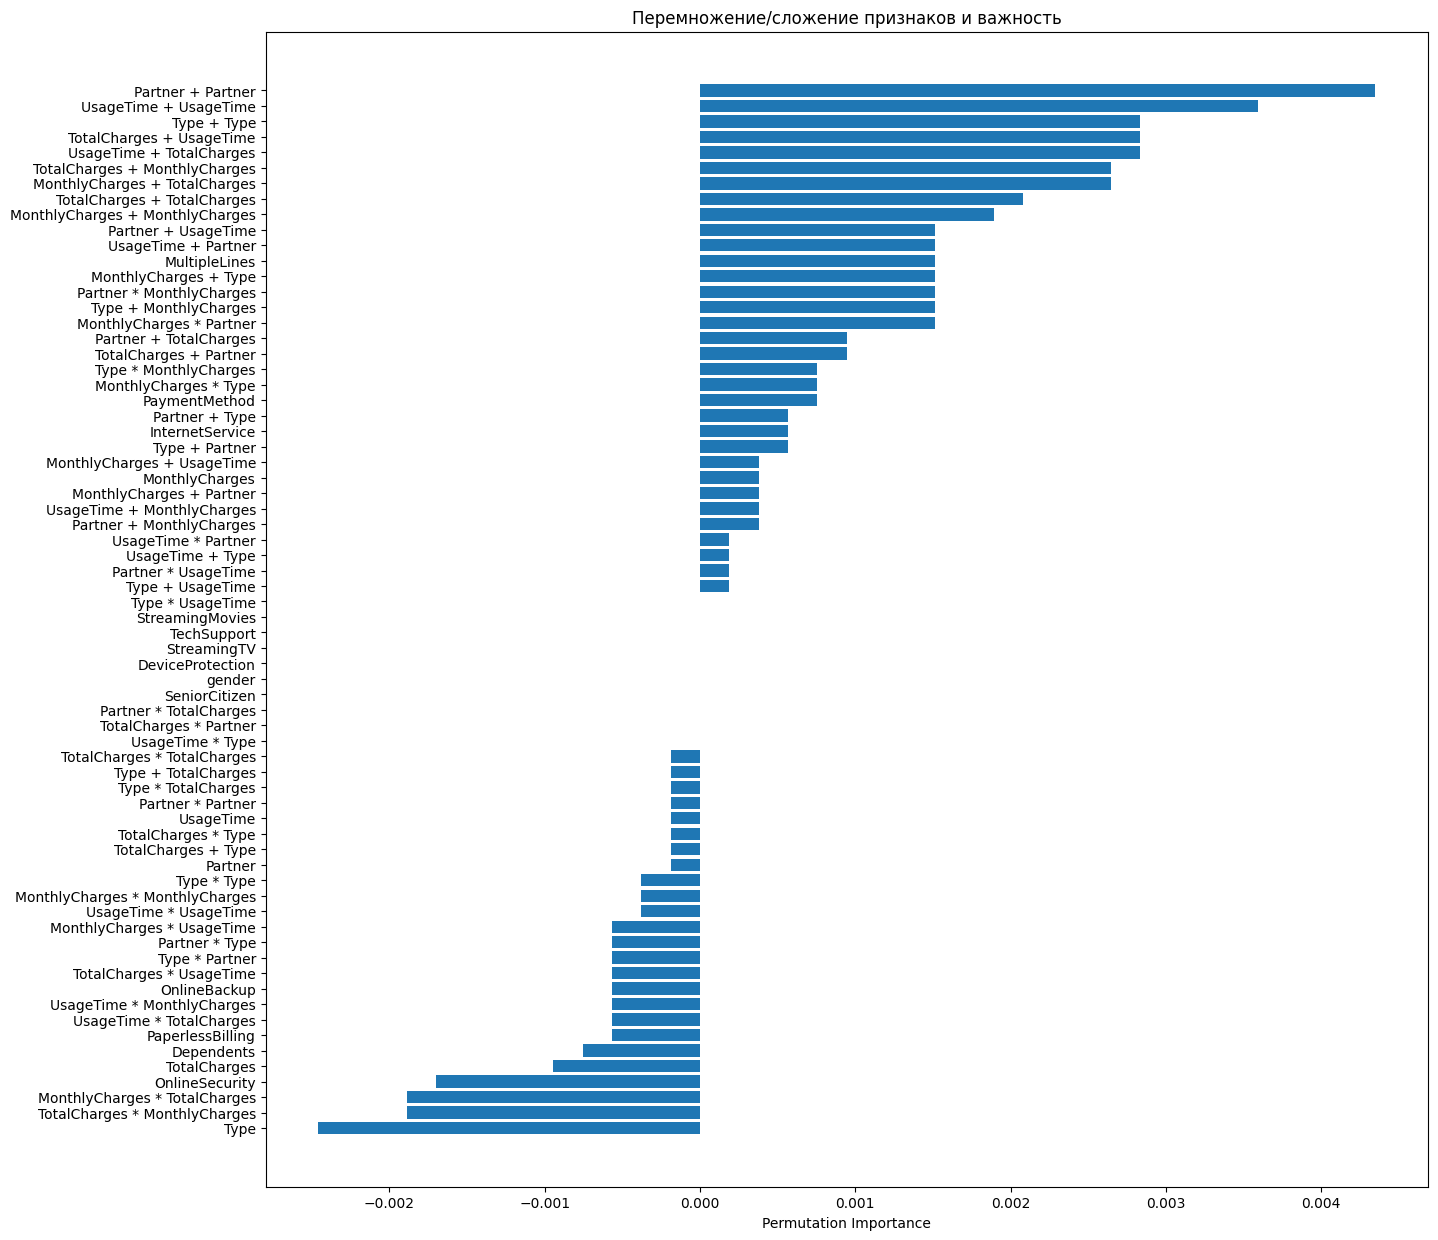

In [53]:
def features_permutation(oscv, shap_values):
    X_train_temp = oscv.best_estimator_['preprocessor'].transform(X_train)
    X_val_temp = oscv.best_estimator_['preprocessor'].transform(X_val)
    X_train_temp = pd.DataFrame(X_train_temp, columns=all_columns)
    X_val_temp = pd.DataFrame(X_val_temp, columns=all_columns)
    shap_importance = np.abs(shap_values.values).mean(axis=0)
    top_5_features_idx = np.argsort(shap_importance)[-5:][::-1]
    top_5_features = np.array(X_train_temp.columns)[top_5_features_idx]
    for feat1 in top_5_features:
        for feat2 in top_5_features:
            X_train_temp[f'{feat1} * {feat2}'] = X_train_temp[feat1] * X_train_temp[feat2]
            X_train_temp[f'{feat1} + {feat2}'] = X_train_temp[feat1] + X_train_temp[feat2]

            X_val_temp[f'{feat1} * {feat2}'] = X_val_temp[feat1] * X_val_temp[feat2]
            X_val_temp[f'{feat1} + {feat2}'] = X_val_temp[feat1] + X_val_temp[feat2]

    temp_model = oscv.best_estimator_['model'].fit(X_train_temp, y_train)

    perm_importance = permutation_importance(temp_model, X_val_temp, y_val, n_repeats=10, random_state=42)
    sorted_idx = perm_importance.importances_mean.argsort()
    plt.figure(figsize=(15, 15))
    plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_train_temp.columns)[sorted_idx])
    plt.xlabel('Permutation Importance')
    plt.title('Перемножение/сложение признаков и важность')
    plt.show()

    
features_permutation(oscv_knn, shap_values_knn_best)

Попробуем взять первые 3 признака из топа и еще раз обучить модель. Кроме того, удалим все слабовлиявшие признаки.

In [54]:
X_train_knn_new_features = pd.DataFrame(oscv_knn.best_estimator_['preprocessor'].transform(X_train) \
                                        , columns=all_columns)

X_train_knn_new_features['UsageTime + UsageTime'] = X_train_knn_new_features['UsageTime'] + X_train_knn_new_features['UsageTime']
X_train_knn_new_features['Type * Type'] = X_train_knn_new_features['Type'] * X_train_knn_new_features['Type']
X_train_knn_new_features['UsageTime + TotalCharges'] = X_train_knn_new_features['UsageTime'] + X_train_knn_new_features['TotalCharges']
X_train_knn_new_features = X_train_knn_new_features[['TotalCharges', 'UsageTime', 'Type', \
                                                                'MonthlyCharges', 'OnlineSecurity','Partner', 'MultipleLines', 'PaymentMethod', \
                                                                'TechSupport', 'UsageTime + UsageTime', 'Type * Type', 'UsageTime + TotalCharges']]

X_val_knn_new_features = pd.DataFrame(oscv_knn.best_estimator_['preprocessor'].transform(X_val) \
                                        , columns=all_columns)

X_val_knn_new_features['UsageTime + UsageTime'] = X_val_knn_new_features['UsageTime'] + X_val_knn_new_features['UsageTime']
X_val_knn_new_features['Type * Type'] = X_val_knn_new_features['Type'] * X_val_knn_new_features['Type']
X_val_knn_new_features['UsageTime + TotalCharges'] = X_val_knn_new_features['UsageTime'] + X_val_knn_new_features['TotalCharges']
X_val_knn_new_features = X_val_knn_new_features[['TotalCharges', 'UsageTime', 'Type', \
                                                                'MonthlyCharges', 'OnlineSecurity','Partner', 'MultipleLines', 'PaymentMethod', \
                                                                'TechSupport', 'UsageTime + UsageTime', 'Type * Type', 'UsageTime + TotalCharges']]



X_train_knn_new_features.head()

,TotalCharges,UsageTime,Type,MonthlyCharges,OnlineSecurity,Partner,MultipleLines,PaymentMethod,TechSupport,UsageTime + UsageTime,Type * Type,UsageTime + TotalCharges
0,1.117101,1.618916,2.0,-0.059469,1.0,0.0,0.0,0.0,1.0,3.237832,4.0,2.736017
1,-0.970430,-1.192141,0.0,-1.309668,0.0,0.0,0.0,0.0,0.0,-2.384283,0.0,-2.162571
2,2.194910,1.884193,2.0,0.842532,1.0,1.0,1.0,1.0,1.0,3.768387,4.0,4.079103
3,-0.717077,-0.567788,0.0,-0.949862,0.0,1.0,0.0,1.0,0.0,-1.135575,0.0,-1.284865
4,-0.346973,1.349242,2.0,-1.437340,0.0,1.0,0.0,0.0,0.0,2.698485,4.0,1.002270


In [55]:
pipe_model = Pipeline(
    [
        ('model', KNeighborsClassifier())
    ]
)

param_grid_knn_model = {
    'model': CategoricalDistribution([KNeighborsClassifier()]),
    'model__n_neighbors': IntDistribution(2, 100)
}

oscv_knn_new_features = OptunaSearchCV(
    pipe_model, 
    param_grid_knn_model, 
    cv=5, 
    scoring='roc_auc',
    n_trials=100, 
    refit='roc_auc',
    random_state=RANDOM_STATE
)

start_time = time.time()
oscv_knn_new_features.fit(X_train_knn_new_features, y_train) 
end_time = time.time()

execution_time_knn_new_features = end_time - start_time

[I 2024-09-12 14:03:34,590] A new study created in memory with name: no-name-a899b4a7-d2e0-4de5-8119-93755ceff063
[I 2024-09-12 14:03:34,763] Trial 0 finished with value: 0.8042479243158326 and parameters: {'model': KNeighborsClassifier(n_neighbors=21), 'model__n_neighbors': 21}. Best is trial 0 with value: 0.8042479243158326.
[I 2024-09-12 14:03:34,975] Trial 1 finished with value: 0.811811360575577 and parameters: {'model': KNeighborsClassifier(n_neighbors=54), 'model__n_neighbors': 54}. Best is trial 1 with value: 0.811811360575577.
[I 2024-09-12 14:03:35,113] Trial 2 finished with value: 0.764580494902507 and parameters: {'model': KNeighborsClassifier(n_neighbors=7), 'model__n_neighbors': 7}. Best is trial 1 with value: 0.811811360575577.
[I 2024-09-12 14:03:35,346] Trial 3 finished with value: 0.8119392104351985 and parameters: {'model': KNeighborsClassifier(n_neighbors=71), 'model__n_neighbors': 71}. Best is trial 3 with value: 0.8119392104351985.
[I 2024-09-12 14:03:35,592] Tria

In [56]:
print('Лучшая метрика при кросс-валидации:', round(oscv_knn_new_features.best_score_, 3))
print('Время обучения и подбора параметров:', round(execution_time_knn_new_features, 2))
start_time = time.time()
oscv_knn_new_features.predict(X_val_knn_new_features)
end_time = time.time()
print('Время предсказания на валидационной выборке:', round(end_time - start_time, 2))
print('Параметры лучшей модели:', oscv_knn_new_features.best_params_)

Лучшая метрика при кросс-валидации: 0.813
Время обучения и подбора параметров: 21.04
Время предсказания на валидационной выборке: 0.04
Параметры лучшей модели: {'model': KNeighborsClassifier(n_neighbors=50), 'model__n_neighbors': 47}


### Вывод

kNN не смог дать нужных результатов. Со стандартной моделью с перебором кодировщиков, скейлеров и параметров модели метрика вышла 0.806. С добавлением перестановки некоторых признаков метрика вышла не сильно лучше. Модель вышла не подходящей. В ходе исследованиё, кроме того, было замечено, что при удалении строк с пропусками эта модель дает метрику 0.813, а при добавлении сочетаний признаков - 0.827, что тоже не подходит, но эта модель лучше работает с удалением пропусков.

## CatBoostClassifier

Попробуем градиентную модель CatBoostClassifier. Перебем параметры.

In [57]:
pipe_boost = Pipeline(
    [
        ('drop_columns', drop_columns_transformer),
        ('preprocessor', ColumnTransformer([('scaler', MinMaxScaler(), num_columns),], remainder='passthrough')),
        ('model', CatBoostClassifier(cat_features=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], \
                                     task_type='GPU', devices='0', random_state=RANDOM_STATE))
    ]
)


param_grid_cb = {
    'model__depth': IntDistribution(4, 10),
    'model__learning_rate': FloatDistribution(0.01, 0.08),
    'preprocessor__scaler':CategoricalDistribution(['passthrough', StandardScaler(), MinMaxScaler()]),
}

oscv_cb = OptunaSearchCV(
    pipe_boost, 
    param_grid_cb, 
    cv=5, 
    scoring='roc_auc', 
    n_trials=1,
    random_state=RANDOM_STATE
)

start_time = time.time()
oscv_cb.fit(X_train, y_train)
end_time = time.time()

execution_time_cb = end_time - start_time

[I 2024-09-12 14:03:55,706] A new study created in memory with name: no-name-850b19db-eb45-4950-ae54-d1f9306c5d70


0:	learn: 0.6103654	total: 97.2ms	remaining: 1m 37s
1:	learn: 0.5413282	total: 127ms	remaining: 1m 3s
2:	learn: 0.4967393	total: 159ms	remaining: 52.9s
3:	learn: 0.4589071	total: 194ms	remaining: 48.3s
4:	learn: 0.4291810	total: 227ms	remaining: 45.1s
5:	learn: 0.4072802	total: 262ms	remaining: 43.4s
6:	learn: 0.3968296	total: 282ms	remaining: 39.9s
7:	learn: 0.3803635	total: 316ms	remaining: 39.2s
8:	learn: 0.3705495	total: 352ms	remaining: 38.8s
9:	learn: 0.3612508	total: 385ms	remaining: 38.1s
10:	learn: 0.3545591	total: 418ms	remaining: 37.6s
11:	learn: 0.3472060	total: 455ms	remaining: 37.5s
12:	learn: 0.3424348	total: 492ms	remaining: 37.3s
13:	learn: 0.3373225	total: 528ms	remaining: 37.2s
14:	learn: 0.3325635	total: 564ms	remaining: 37.1s
15:	learn: 0.3293341	total: 601ms	remaining: 37s
16:	learn: 0.3255892	total: 635ms	remaining: 36.7s
17:	learn: 0.3230173	total: 674ms	remaining: 36.8s
18:	learn: 0.3207536	total: 712ms	remaining: 36.8s
19:	learn: 0.3185089	total: 747ms	remaini

[I 2024-09-12 14:07:22,609] Trial 0 finished with value: 0.8927453735746276 and parameters: {'model__depth': 5, 'model__learning_rate': 0.1107736490651079, 'preprocessor__scaler': MinMaxScaler()}. Best is trial 0 with value: 0.8927453735746276.


998:	learn: 0.1514474	total: 42.5s	remaining: 42.6ms
999:	learn: 0.1514464	total: 42.6s	remaining: 0us
0:	learn: 0.6073016	total: 44.7ms	remaining: 44.6s
1:	learn: 0.5430824	total: 80.1ms	remaining: 40s
2:	learn: 0.4997036	total: 121ms	remaining: 40.4s
3:	learn: 0.4554471	total: 165ms	remaining: 41.2s
4:	learn: 0.4275225	total: 210ms	remaining: 41.8s
5:	learn: 0.4040255	total: 252ms	remaining: 41.8s
6:	learn: 0.3882291	total: 298ms	remaining: 42.3s
7:	learn: 0.3774243	total: 341ms	remaining: 42.3s
8:	learn: 0.3659761	total: 384ms	remaining: 42.3s
9:	learn: 0.3578070	total: 432ms	remaining: 42.7s
10:	learn: 0.3507184	total: 480ms	remaining: 43.1s
11:	learn: 0.3440592	total: 526ms	remaining: 43.3s
12:	learn: 0.3394169	total: 569ms	remaining: 43.2s
13:	learn: 0.3359093	total: 614ms	remaining: 43.3s
14:	learn: 0.3315718	total: 661ms	remaining: 43.4s
15:	learn: 0.3298531	total: 716ms	remaining: 44s
16:	learn: 0.3265927	total: 766ms	remaining: 44.3s
17:	learn: 0.3240086	total: 812ms	remainin

In [58]:
print('Лучшая метрика при кросс-валидации:', round(oscv_cb.best_score_, 3))
print('Время обучения и подбора параметров:', round(execution_time_cb, 2))
start_time = time.time()
oscv_cb.predict(X_val)
end_time = time.time()
print('Время предсказания на валидационной выборке:', round(end_time - start_time, 2))
print('Параметры лучшей модели:', oscv_cb.best_params_)

Лучшая метрика при кросс-валидации: 0.893
Время обучения и подбора параметров: 256.51
Время предсказания на валидационной выборке: 0.01
Параметры лучшей модели: {'model__depth': 5, 'model__learning_rate': 0.1107736490651079, 'preprocessor__scaler': MinMaxScaler()}


Метрика получилась подходящей, можно ничего не улучшать, выведем важность признаков и уберем наименее влиющие.

In [59]:
all_columns = num_columns + cat_columns
pd.Series(oscv_cb.best_estimator_['model'].feature_importances_, index=all_columns).sort_values(ascending=False)

UsageTime           57.925233
TotalCharges        13.554731
MonthlyCharges       8.767043
Type                 6.486725
PaymentMethod        2.990051
Partner              2.483129
MultipleLines        1.769236
OnlineBackup         1.664924
PaperlessBilling     1.395574
Dependents           0.989132
OnlineSecurity       0.566052
SeniorCitizen        0.486027
DeviceProtection     0.482253
TechSupport          0.226818
StreamingTV          0.116398
gender               0.096674
InternetService      0.000000
StreamingMovies      0.000000
dtype: float64

Уберем все признаки, у которых важность меньше 1.

In [60]:
X_train_cb = pd.DataFrame(oscv_cb.best_estimator_['preprocessor'].fit_transform(oscv_cb.best_estimator_['drop_columns'].fit_transform(X_train)), columns=all_columns)
X_train_cb = X_train_cb[['UsageTime', 'TotalCharges', 'MonthlyCharges', 'Type', 'PaymentMethod', 'Partner', 'MultipleLines', 'PaperlessBilling', 'OnlineBackup']]
X_train_cb.head()

,UsageTime,TotalCharges,MonthlyCharges,Type,PaymentMethod,Partner,MultipleLines,PaperlessBilling,OnlineBackup
0,0.868626,0.482044,0.440299,Two year,Bank transfer (automatic),No,No,Yes,Yes
1,0.039758,0.006009,0.065174,Month-to-month,Bank transfer (automatic),No,No,No,No
2,0.946845,0.727824,0.710945,Two year,Credit card (automatic),Yes,Yes,No,Yes
3,0.223855,0.063783,0.173134,Month-to-month,Credit card (automatic),Yes,No,Yes,Yes
4,0.78911,0.148181,0.026866,Two year,Bank transfer (automatic),Yes,No,Yes,No


In [61]:
oscv_cb.best_params_

{'model__depth': 5,
 'model__learning_rate': 0.1107736490651079,
 'preprocessor__scaler': MinMaxScaler()}

Посмотрим метрику при кросс-валидации.

In [62]:
print('ROC-AUC при удалении признаков у лучшей модели:', cross_val_score(CatBoostClassifier(depth=5, learning_rate=0.1107736490651079, cat_features=['Type', 'PaymentMethod', 'Partner', 'MultipleLines', 'PaperlessBilling', 'OnlineBackup'], random_state=RANDOM_STATE, verbose=0), X_train_cb, y_train, cv=5, scoring='roc_auc'))
model_cb = CatBoostClassifier(depth=5, learning_rate=0.1107736490651079, cat_features=['Type', 'PaymentMethod', 'Partner', 'MultipleLines', 'PaperlessBilling', 'OnlineBackup'], random_state=RANDOM_STATE, verbose=0).fit(X_train_cb, y_train)

ROC-AUC при удалении признаков у лучшей модели: [0.88856193 0.91025575 0.9176993  0.89721926 0.88435975]


Если усреднить эти показатели метрика выйдет не сильно лучше получившейся. Первые 3 признака у нас числовые, мы можем создать из них новые признаки. Попробуем это сделать и вывести важность.

In [63]:
X_train_cb['UsageTime + TotalCharges + MonthlyCharges'] = X_train_cb['UsageTime'] + X_train_cb['TotalCharges'] + X_train_cb['MonthlyCharges']
X_train_cb['UsageTime + TotalCharges'] = X_train_cb['UsageTime'] + X_train_cb['TotalCharges']
X_train_cb['UsageTime + MonthlyCharges'] = X_train_cb['UsageTime'] + X_train_cb['MonthlyCharges']
X_train_cb['TotalCharges + MonthlyCharges'] = X_train_cb['TotalCharges'] + X_train_cb['MonthlyCharges']
model_cb_new_features = CatBoostClassifier(depth=5, learning_rate=0.1107736490651079, cat_features=\
                                           ['Type', 'PaymentMethod', 'Partner', 'MultipleLines', 'PaperlessBilling', 'OnlineBackup'],\
                                           random_state=RANDOM_STATE, verbose=1).fit(X_train_cb, y_train)

0:	learn: 0.6064018	total: 20ms	remaining: 19.9s
1:	learn: 0.5473787	total: 58.6ms	remaining: 29.3s
2:	learn: 0.4993707	total: 85.2ms	remaining: 28.3s
3:	learn: 0.4648686	total: 111ms	remaining: 27.6s
4:	learn: 0.4354156	total: 132ms	remaining: 26.3s
5:	learn: 0.4143554	total: 150ms	remaining: 24.9s
6:	learn: 0.3974669	total: 171ms	remaining: 24.3s
7:	learn: 0.3824294	total: 192ms	remaining: 23.8s
8:	learn: 0.3755045	total: 208ms	remaining: 22.9s
9:	learn: 0.3667829	total: 234ms	remaining: 23.1s
10:	learn: 0.3587634	total: 264ms	remaining: 23.7s
11:	learn: 0.3532290	total: 289ms	remaining: 23.8s
12:	learn: 0.3490053	total: 319ms	remaining: 24.2s
13:	learn: 0.3449912	total: 341ms	remaining: 24s
14:	learn: 0.3408302	total: 366ms	remaining: 24s
15:	learn: 0.3377630	total: 389ms	remaining: 23.9s
16:	learn: 0.3342079	total: 421ms	remaining: 24.3s
17:	learn: 0.3323636	total: 451ms	remaining: 24.6s
18:	learn: 0.3294644	total: 488ms	remaining: 25.2s
19:	learn: 0.3269932	total: 509ms	remaining:

In [64]:
pd.Series(model_cb_new_features.feature_importances_, index=['UsageTime', 'TotalCharges', 'MonthlyCharges', 'Type', \
                                                             'PaymentMethod', 'Partner', 'MultipleLines', 'PaperlessBilling', 'OnlineBackup',\
                                                            'UsageTime + TotalCharges + MonthlyCharges', 'UsageTime + TotalCharges', \
                                                            'UsageTime + MonthlyCharges', 'TotalCharges + MonthlyCharges']).sort_values(ascending=False)

UsageTime                                    34.649606
MonthlyCharges                                9.102745
TotalCharges                                  8.528556
Type                                          8.377957
UsageTime + TotalCharges                      6.932008
TotalCharges + MonthlyCharges                 6.693769
UsageTime + MonthlyCharges                    5.644876
UsageTime + TotalCharges + MonthlyCharges     5.195086
PaymentMethod                                 5.095149
Partner                                       3.157108
OnlineBackup                                  2.260742
PaperlessBilling                              2.224817
MultipleLines                                 2.137581
dtype: float64

Посмотрим метрику.

In [65]:
print('ROC-AUC при удалении признаков у лучшей модели:', cross_val_score(CatBoostClassifier(depth=5, learning_rate=0.1107736490651079, cat_features=['Type', 'PaymentMethod', 'Partner', 'MultipleLines', 'PaperlessBilling', 'OnlineBackup'], random_state=RANDOM_STATE, verbose=0), X_train_cb, y_train, cv=5, scoring='roc_auc'))

ROC-AUC при удалении признаков у лучшей модели: [0.86068511 0.90054902 0.89358736 0.88370985 0.87890053]


С добавлением признаков метрика только упала, и модель, вероятно, переобучилась под данные с таким добавление. Будем использовать самую станадартную модель.

# Вывод

Лучшей из двух моделей получилась CatBoost. Её метрики представлены ниже.

In [66]:
print('Лучшая метрика при кросс-валидации:', round(oscv_cb.best_score_, 3))
print('Время обучения и подбора параметров:', round(execution_time_cb, 2))
start_time = time.time()
oscv_cb.predict(X_val)
end_time = time.time()
print('Время предсказания на валидационной выборке:', round(end_time - start_time, 2))
print('Параметры лучшей модели:', oscv_cb.best_params_)

Лучшая метрика при кросс-валидации: 0.893
Время обучения и подбора параметров: 256.51
Время предсказания на валидационной выборке: 0.02
Параметры лучшей модели: {'model__depth': 5, 'model__learning_rate': 0.1107736490651079, 'preprocessor__scaler': MinMaxScaler()}


Посмотрим метрику на тестовой выборке.

In [67]:
print('Метрика на тестовой выборке:', round(roc_auc_score(oscv_cb.predict(X_test), y_test), 3))
start_time = time.time()
oscv_cb.predict(X_test)
end_time = time.time()
print('Время предсказания на тестовой выборке:', round(end_time - start_time, 2))

Метрика на тестовой выборке: 0.926
Время предсказания на тестовой выборке: 0.02


Метрика вышла еще лучше, что хорошо. 

В ходе исследования были выполнены загрузка данных, предобработка данных, исследовательский анализ данных и обучение моделей.

Была проведена базовая предобработка данных, включающая проверку на пропуски, соответствие типов данных и дубликаты. Данные были приведены к правильному виду: типы данных были корректно приведены, пропуски и дубликаты не обнаружены.

В ходе анализа данные были объединены в единую таблицу и исследованы по количественным и категориальным признакам. Графический анализ показал схожесть распределения большинства признаков. Обнаружено, что корреляция признаков с таргетом оказалась не слишком высокой, что может свидетельствовать о необходимости дальнейшего поиска более значимых факторов. 

Из рассмотренных моделей наилучшими результатами показала модель CatBoost. В ходе обучения моделей были подобраны гиперпараметры для лучшего совмещения с данными. Кроме того, для повышения метрик были подобраны сочетания параметров и удалены ненужные признаки, но это не дало результата.